# Librerias

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import lightgbm as lgb
import os
from datetime import datetime
import seaborn as sns
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
import joblib
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.naive_bayes import GaussianNB
from collections import Counter

# Preprocesado de Datos

In [2]:
def agregar_lags(df, columna, lags):
    for lag in lags:
        df[f'lag_{lag}'] = df[columna].shift(lag)
    return df

def agregar_medias_moviles(df, columna, ventanas):
    for ventana in ventanas:
        df[f'media_movil_{ventana}'] = df[columna].shift(1).rolling(window=ventana, min_periods=1).mean()
    return df

def agregar_variables_ciclicas(df, columna_mes, columna_fecha):
    df['mes_sin'] = np.sin(2 * np.pi * df[columna_mes] / 12)
    df['mes_cos'] = np.cos(2 * np.pi * df[columna_mes] / 12)
    df['dia_semana_sin'] = np.sin(2 * np.pi * pd.to_datetime(df[columna_fecha]).dt.weekday / 7)
    df['dia_semana_cos'] = np.cos(2 * np.pi * pd.to_datetime(df[columna_fecha]).dt.weekday / 7)
    return df

def agregar_ewma(df, columna, spans):
    for span in spans:
        df[f'ewma_{span}'] = df[columna].shift(1).ewm(span=span, adjust=False).mean()
    return df

def transformacion_a_clasificacion(df, class_range):
    max = ((df['Accesos'].max())//class_range)+2
    bins = [0]
    labels = []
    for i in range(max):
        bins.append((i+1)*class_range)
        labels.append(i)
    df['Accesos'] = pd.cut(df['Accesos'], bins=bins, labels=labels, right=False)
    return df
    
def obtener_semestre(mes):
    if 3 <= mes <= 7:
        return 1  # Primer semestre
    elif 8 <= mes <= 12:
        return 2  # Segundo semestre
    else:
        return 0  # Fuera de semestre (enero, febrero)
    
def obtener_semana_semestre(fecha):
    mes = fecha.month
    dia = fecha.day
    if 3 <= mes <= 7:
        inicio_semestre = datetime(fecha.year, 3, 1)
    elif 8 <= mes <= 12:
        inicio_semestre = datetime(fecha.year, 8, 1)
    else:
        return 0  # Fuera de semestre
    delta = fecha - inicio_semestre
    semana_semestre = delta.days // 7 + 1
    return semana_semestre

In [3]:
try:
    df = pd.read_csv("Datasets/accesos_biblioteca.csv")
    print("Dataset cargado desde 'Datasets/accesos_biblioteca.csv'")
except FileNotFoundError:
    print("ERROR: No se encontró el archivo 'accesos_biblioteca.csv'.")
    exit(1)

Dataset cargado desde 'Datasets/accesos_biblioteca.csv'


In [4]:
for col in ['Accesos']:
    df[col] = df[col].fillna(0).astype(int)

df = df[
    pd.to_datetime(df['Fecha']).dt.weekday != 6
].reset_index(drop=True)

df = agregar_medias_moviles(df, 'Accesos', [7, 14, 30])
df = agregar_variables_ciclicas(df, 'Mes', 'Fecha')
df = agregar_ewma(df, 'Accesos', [7, 14, 30])

df['Semestre'] = df['Mes'].apply(obtener_semestre)
df['Semana_Semestre'] = pd.to_datetime(df['Fecha']).apply(obtener_semana_semestre)

df['Fecha'] = pd.to_datetime(df['Fecha'])

df = agregar_lags(df, 'Accesos', [7, 14, 21])
df = transformacion_a_clasificacion(df, 500)

df = df.dropna().reset_index(drop=True)
df.tail(5)

,Fecha,Día,Mes,Año,Semestre,Accesos,Vacaciones?,media_movil_7,media_movil_14,media_movil_30,...,mes_cos,dia_semana_sin,dia_semana_cos,ewma_7,ewma_14,ewma_30,Semana_Semestre,lag_7,lag_14,lag_21
412,2025-05-02,2,5,2025,1,0,1,1585.571429,1941.642857,2525.500000,...,-0.866025,-0.433884,-0.900969,1525.983140,1921.208321,2153.063866,9,2544.0,4145.0,3923.0
413,2025-05-03,3,5,2025,1,0,1,1222.142857,1645.571429,2445.066667,...,-0.866025,-0.974928,-0.222521,1144.487355,1665.047212,2014.156520,10,1356.0,1592.0,4248.0
414,2025-05-05,5,5,2025,1,5,0,1028.428571,1531.857143,2438.466667,...,-0.866025,0.000000,1.000000,858.365516,1443.040917,1884.210938,10,526.0,0.0,3976.0
415,2025-05-06,6,5,2025,1,3,0,1346.142857,1728.285714,2417.700000,...,-0.866025,0.781831,0.623490,1331.274137,1617.302128,1940.068296,10,2400.0,0.0,3140.0
416,2025-05-07,7,5,2025,1,4,0,1269.857143,1861.571429,2362.766667,...,-0.866025,0.974928,-0.222521,1464.955603,1650.461844,1935.289697,10,2568.0,3841.0,852.0


In [5]:
X = df.drop(columns=['Fecha', 'Accesos'])
y = df['Accesos']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

# Visualizacion de Datos

In [6]:
print(f"Datos de entrenamiento: {len(X_train)}")
print(f"Datos de prueba: {len(X_test)}")

Datos de entrenamiento: 333
Datos de prueba: 84


In [7]:
df.tail(5)

,Fecha,Día,Mes,Año,Semestre,Accesos,Vacaciones?,media_movil_7,media_movil_14,media_movil_30,...,mes_cos,dia_semana_sin,dia_semana_cos,ewma_7,ewma_14,ewma_30,Semana_Semestre,lag_7,lag_14,lag_21
412,2025-05-02,2,5,2025,1,0,1,1585.571429,1941.642857,2525.500000,...,-0.866025,-0.433884,-0.900969,1525.983140,1921.208321,2153.063866,9,2544.0,4145.0,3923.0
413,2025-05-03,3,5,2025,1,0,1,1222.142857,1645.571429,2445.066667,...,-0.866025,-0.974928,-0.222521,1144.487355,1665.047212,2014.156520,10,1356.0,1592.0,4248.0
414,2025-05-05,5,5,2025,1,5,0,1028.428571,1531.857143,2438.466667,...,-0.866025,0.000000,1.000000,858.365516,1443.040917,1884.210938,10,526.0,0.0,3976.0
415,2025-05-06,6,5,2025,1,3,0,1346.142857,1728.285714,2417.700000,...,-0.866025,0.781831,0.623490,1331.274137,1617.302128,1940.068296,10,2400.0,0.0,3140.0
416,2025-05-07,7,5,2025,1,4,0,1269.857143,1861.571429,2362.766667,...,-0.866025,0.974928,-0.222521,1464.955603,1650.461844,1935.289697,10,2568.0,3841.0,852.0


In [8]:
print(" Nuevas columnas creadas \n")

# Columnas originales del dataset base
columnas_originales = ['Fecha', 'Día', 'Mes', 'Año', 'Vacaciones', 'Accesos']

# Mostrar todas las columnas actuales
columnas_actuales = list(df.columns)
nuevas_columnas = [col for col in columnas_actuales if col not in columnas_originales]

print(" Dataset original - Columnas iniciales:")
print(f"   Columnas: {columnas_originales}")
print(f"   Total: {len(columnas_originales)} columnas\n")

print(" Nuevas columnas agregadas:")
for i, col in enumerate(nuevas_columnas, 1):
    print(f"   {i:2d}. {col}")

print(f" Resumen de columnas")
print(f" Columnas originales: {len(columnas_originales)}")
print(f" Nuevas columnas: {len(nuevas_columnas)}")
print(f" Total final: {len(columnas_actuales)} columnas")
print(f" Shape del dataset: {df.shape}")

print(f" Categorías de nuevas características:")
print("  Variables de tendencia: media_movil_7, media_movil_14, media_movil_30")
print("  Variables cíclicas: mes_sin, mes_cos, dia_semana_sin, dia_semana_cos") 
print("  Medias exponenciales: ewma_7, ewma_14, ewma_30")
print("  Variables académicas: Semestre, Semana_Semestre, Semana_Certamen")
print("  Variables lag: lag_7, lag_14, lag_21 (se agregarán después)")

# Mostrar una muestra del dataset con las nuevas columnas
print("\n Muestra del Dataset con nuevas columnas:")
print(df[['Fecha', 'Accesos'] + nuevas_columnas[:5]].head(3))

 Nuevas columnas creadas 

 Dataset original - Columnas iniciales:
   Columnas: ['Fecha', 'Día', 'Mes', 'Año', 'Vacaciones', 'Accesos']
   Total: 6 columnas

 Nuevas columnas agregadas:
    1. Semestre
    2. Vacaciones?
    3. media_movil_7
    4. media_movil_14
    5. media_movil_30
    6. mes_sin
    7. mes_cos
    8. dia_semana_sin
    9. dia_semana_cos
   10. ewma_7
   11. ewma_14
   12. ewma_30
   13. Semana_Semestre
   14. lag_7
   15. lag_14
   16. lag_21
 Resumen de columnas
 Columnas originales: 6
 Nuevas columnas: 16
 Total final: 21 columnas
 Shape del dataset: (417, 21)
 Categorías de nuevas características:
  Variables de tendencia: media_movil_7, media_movil_14, media_movil_30
  Variables cíclicas: mes_sin, mes_cos, dia_semana_sin, dia_semana_cos
  Medias exponenciales: ewma_7, ewma_14, ewma_30
  Variables académicas: Semestre, Semana_Semestre, Semana_Certamen
  Variables lag: lag_7, lag_14, lag_21 (se agregarán después)

 Muestra del Dataset con nuevas columnas:
       

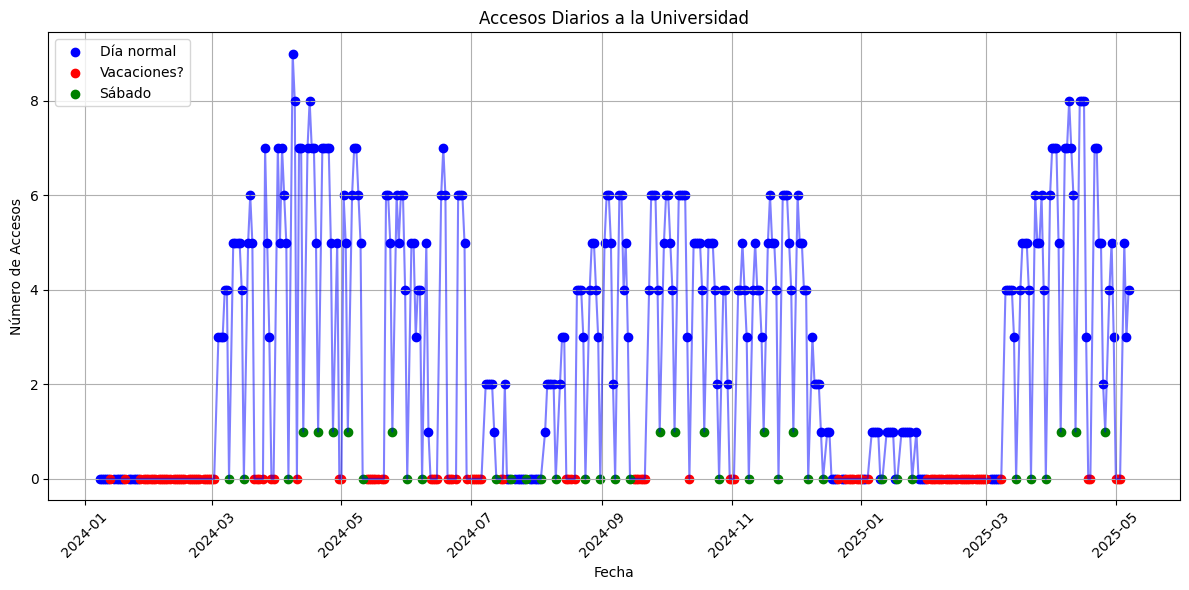

In [9]:
plt.figure(figsize=(12, 6))
plt.plot(df['Fecha'], df['Accesos'], linestyle='-', color='b', alpha=0.5)

# Puntos normales (no vacaciones ni sábados)
no_vac_no_sab = (df['Vacaciones?'] == 0) & (df['Fecha'].dt.weekday != 5)
plt.scatter(df['Fecha'][no_vac_no_sab], df['Accesos'][no_vac_no_sab], color='b', label='Día normal')

# Puntos de vacaciones
vac = (df['Vacaciones?'] == 1)
plt.scatter(df['Fecha'][vac], df['Accesos'][vac], color='r', label='Vacaciones?')

# Puntos de sábados
sab = (df['Vacaciones?'] == 0) & (df['Fecha'].dt.weekday == 5)
plt.scatter(df['Fecha'][sab], df['Accesos'][sab], color='g', label='Sábado')

plt.title('Accesos Diarios a la Universidad')
plt.xlabel('Fecha')
plt.ylabel('Número de Accesos')
plt.xticks(rotation=45)
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

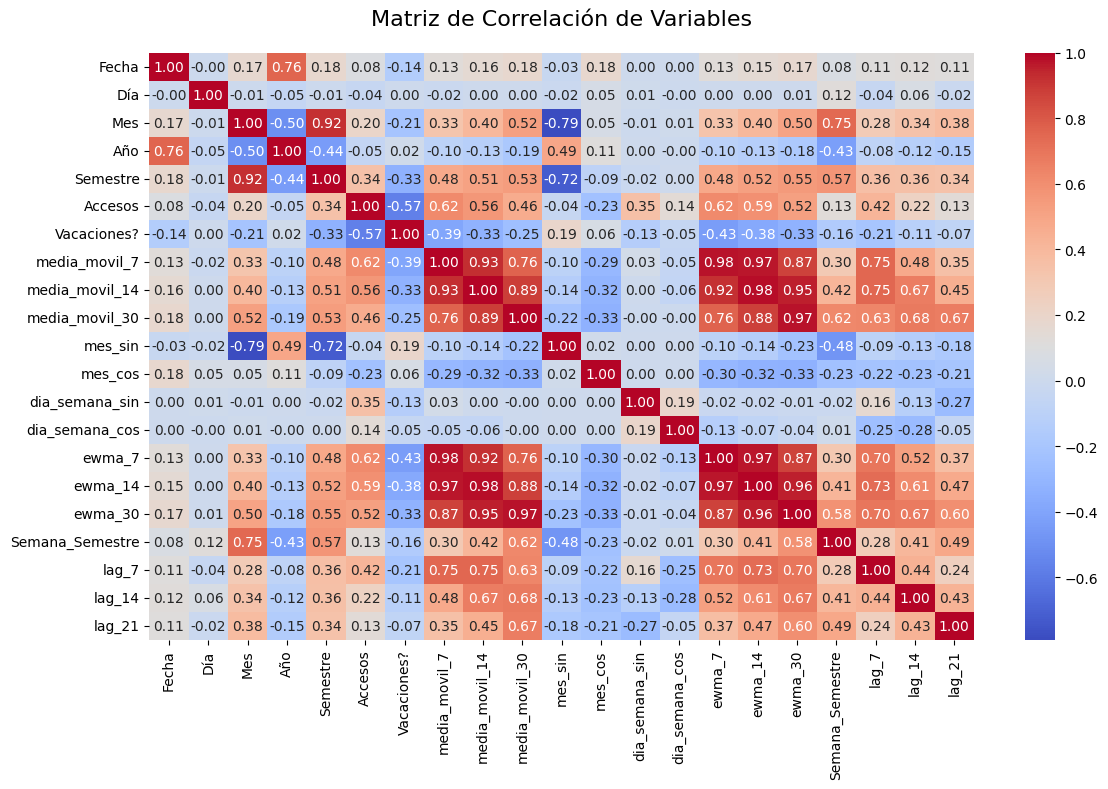

In [10]:
# Matriz de coorrelación
plt.figure(figsize=(12, 8))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Matriz de Correlación de Variables', fontsize=16, pad=20)
plt.tight_layout()
plt.show()

In [11]:
print("Dataset final después de ingeneiría de características\n")

# Mostrar todas las columnas finales organizadas por categoría
print("Columnas organizadas por categoría:")

print("\n Variables originales:")
originales = ['Fecha', 'Día', 'Mes', 'Año', 'Vacaciones', 'Accesos']
for col in originales:
    if col in df.columns:
        print(f" {col}")

print("\n Variables de tendencia/suavizado:")
tendencia = [col for col in df.columns if 'media_movil' in col or 'ewma' in col]
for col in tendencia:
    print(f" {col}")

print("\n Variables cíclicas/temporales:")
ciclicas = [col for col in df.columns if any(x in col for x in ['sin', 'cos'])]
for col in ciclicas:
    print(f" {col}")

print("\n Variables del contexto académico:")
academicas = [col for col in df.columns if any(x in col for x in ['Semestre', 'Semana', 'Certamen'])]
for col in academicas:
    print(f" {col}")

print("\n Variables lag (retardos temporales):")
lags = [col for col in df.columns if 'lag_' in col]
for col in lags:
    print(f" {col}")

print(f"\n Resumen Final:")
print(f" Total de columnas: {len(df.columns)}")
print(f" Filas en el dataset: {len(df)}")
print(f" Nuevas características creadas: {len(df.columns) - 6}")  # 6 son las originales

Dataset final después de ingeneiría de características

Columnas organizadas por categoría:

 Variables originales:
 Fecha
 Día
 Mes
 Año
 Accesos

 Variables de tendencia/suavizado:
 media_movil_7
 media_movil_14
 media_movil_30
 ewma_7
 ewma_14
 ewma_30

 Variables cíclicas/temporales:
 mes_sin
 mes_cos
 dia_semana_sin
 dia_semana_cos

 Variables del contexto académico:
 Semestre
 Semana_Semestre

 Variables lag (retardos temporales):
 lag_7
 lag_14
 lag_21

 Resumen Final:
 Total de columnas: 21
 Filas en el dataset: 417
 Nuevas características creadas: 15


# Funciones Utiles

In [12]:
def graph_pred(Y_pred, Model):
    results_df = pd.DataFrame({
        'Índice': X_test.index,
        'Real': y_test,
        'Predicción': Y_pred
    }).sort_values(by='Índice')

    plt.figure(figsize=(12, 6))
    plt.plot(results_df['Índice'], results_df['Real'], label='Real', color='blue', linewidth=2)
    plt.plot(results_df['Índice'], results_df['Predicción'], label='Predicción', color='green', linestyle='--', linewidth=2)
    plt.title('Resultados de Predicción', fontsize=14)
    plt.xlabel('Índice', fontsize=12)
    plt.ylabel('Número de Accesos', fontsize=12)
    plt.xticks(rotation=45)
    plt.legend(fontsize=10)
    plt.grid(alpha=0.5)
    plt.tight_layout()
    plt.savefig(f'{Model}_predicciones.png')

# Random Forest

In [13]:
X = df.drop(columns=['Fecha', 'Accesos'])
y = df['Accesos']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

In [14]:
os.makedirs('Archivos Auxiliares Class', exist_ok=True)
if "modelo_RandomForest.pkl" not in os.listdir('Archivos Auxiliares Class'):
    tscv = TimeSeriesSplit(n_splits=5)
    param_grid = {
        'n_estimators': [100, 300, 500, 1000],
        'max_depth': [3, 5, 8, None],
        'min_samples_split': [2, 5, 8, 10],
        'min_samples_leaf': [1, 2, 4, 8],
        'max_features': [None, 'sqrt', 'log2', 0.8, 0.4]
    }
    grid_search = GridSearchCV(
        RandomForestClassifier(random_state=42, class_weight='balanced'),
        param_grid,
        cv=tscv,
        scoring='f1_weighted',
        n_jobs=-1,
        verbose=2 # Aumentamos el verbose para seguir mejor el progreso
    )
    grid_search.fit(X_train, y_train)
    best_params = grid_search.best_params_
    model = RandomForestClassifier(**best_params, random_state=42, class_weight='balanced')
    model.fit(X_train, y_train)
    joblib.dump(model, 'Archivos Auxiliares Class/modelo_RandomForest.pkl')
    print("Modelo guardado como 'Archivos Auxiliares Class/modelo_RandomForest.pkl'")
else:
    model = joblib.load('Archivos Auxiliares Class/modelo_RandomForest.pkl')
    print("Modelo cargado desde 'Archivos Auxiliares Class/modelo_RandomForest.pkl'")

Modelo cargado desde 'Archivos Auxiliares Class/modelo_RandomForest.pkl'


In [15]:
# Importancia de las características
importancias = model.feature_importances_
indices = np.argsort(importancias)[::-1]
print("\n Importancia de las características \n")
for i in range(X.shape[1]):
    print(f"{i + 1:2d}. {X.columns[indices[i]]}: {importancias[indices[i]]:.4f}")


 Importancia de las características 

 1. media_movil_7: 0.1032
 2. lag_7: 0.0790
 3. ewma_7: 0.0737
 4. media_movil_30: 0.0708
 5. ewma_14: 0.0599
 6. media_movil_14: 0.0592
 7. dia_semana_sin: 0.0584
 8. lag_14: 0.0578
 9. Semana_Semestre: 0.0550
10. lag_21: 0.0523
11. mes_sin: 0.0507
12. ewma_30: 0.0496
13. Día: 0.0480
14. Mes: 0.0470
15. Vacaciones?: 0.0397
16. dia_semana_cos: 0.0305
17. mes_cos: 0.0253
18. Año: 0.0200
19. Semestre: 0.0198


In [16]:
# Eliminar características con importancia menor a 0.01
umbral_importancia = 0.01
caracteristicas_seleccionadas = X.columns[importancias >= umbral_importancia]
X_train = X_train[caracteristicas_seleccionadas]
X_test = X_test[caracteristicas_seleccionadas]

#Reentrenar el modelo con las características seleccionadas
model.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,4
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [17]:
Y_pred = model.predict(X_test)

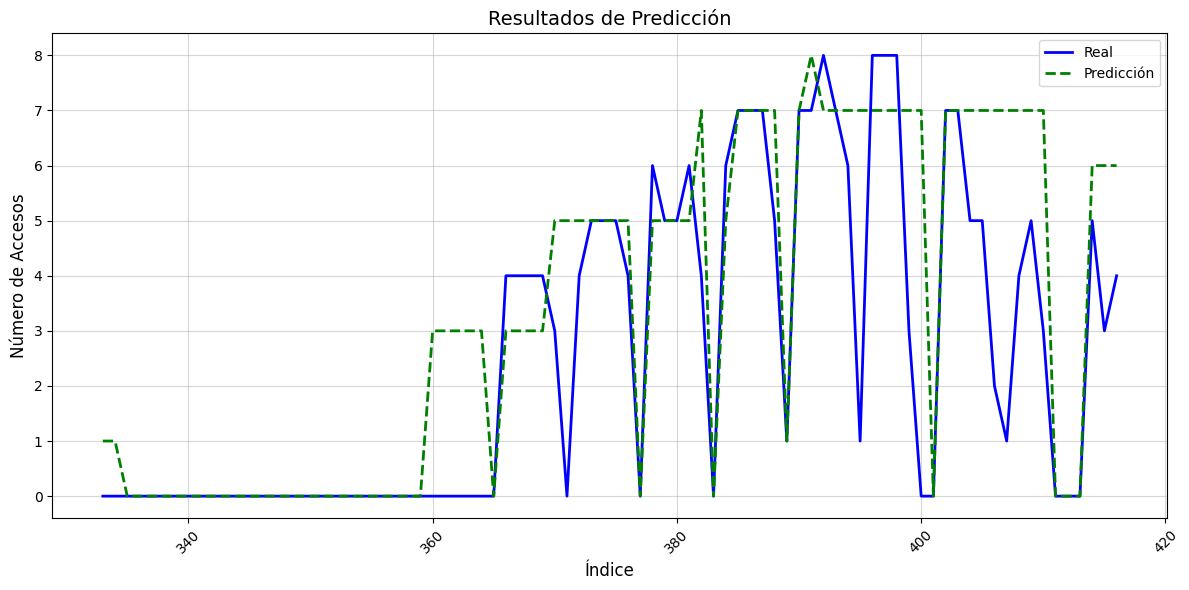

In [18]:
graph_pred(Y_pred, 'RandomForest_C')

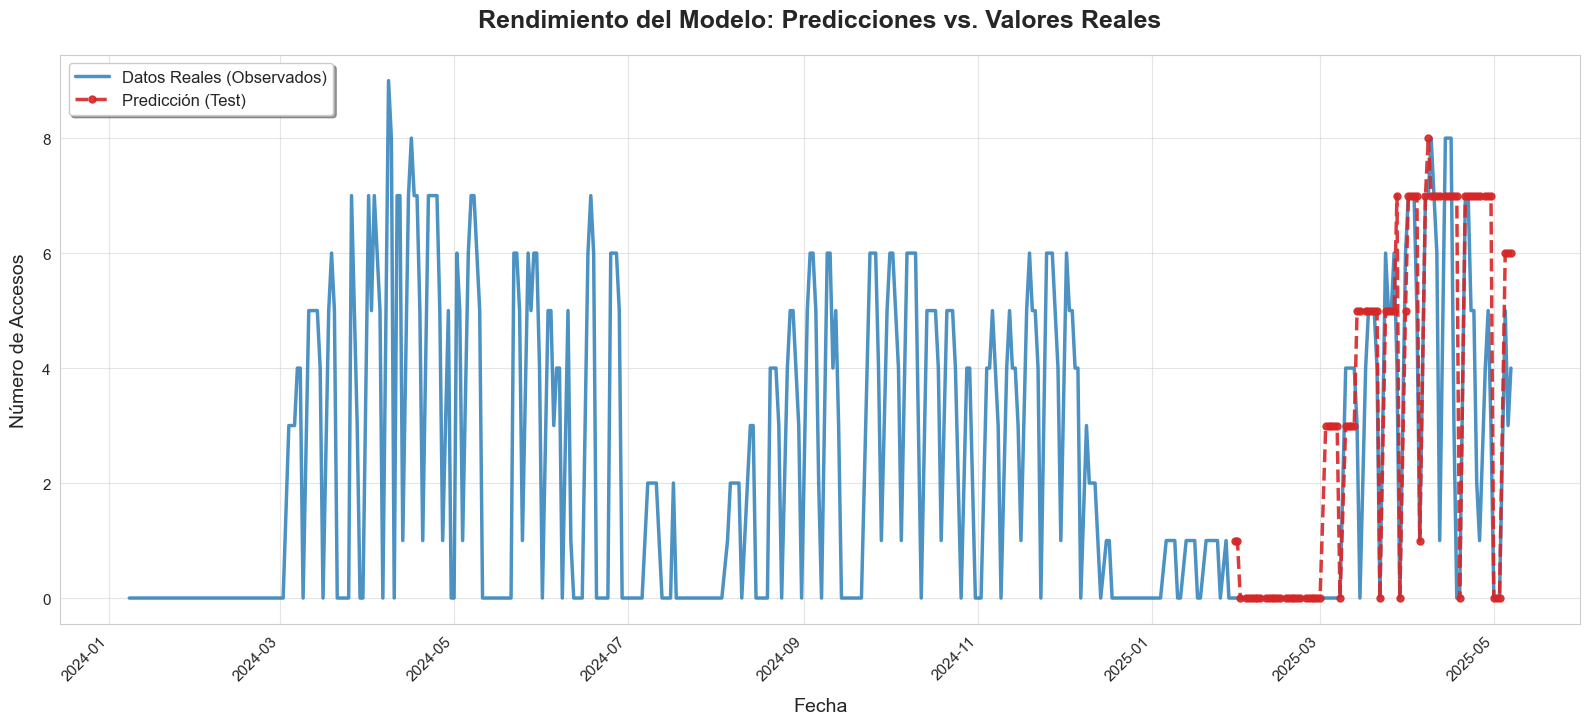

0.5356030955346024
              precision    recall  f1-score   support

           0       1.00      0.78      0.88        41
           1       0.33      0.33      0.33         3
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         4
           4       0.00      0.00      0.00         9
           5       0.42      0.50      0.45        10
           6       0.00      0.00      0.00         4
           7       0.29      0.88      0.44         8
           8       0.00      0.00      0.00         4

    accuracy                           0.54        84
   macro avg       0.23      0.28      0.23        84
weighted avg       0.58      0.54      0.54        84

[[32  2  0  5  0  1  0  1  0]
 [ 0  1  0  0  0  0  0  2  0]
 [ 0  0  0  0  0  0  0  1  0]
 [ 0  0  0  0  0  1  1  2  0]
 [ 0  0  0  4  0  2  1  2  0]
 [ 0  0  0  0  0  5  1  4  0]
 [ 0  0  0  0  0  3  0  1  0]
 [ 0  0  0  0  0  0  0  7  1]
 [ 0  0  0  0  0  0  0  4  0]]


s:\Universidad\Analisis_de_Datos\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
s:\Universidad\Analisis_de_Datos\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
s:\Universidad\Analisis_de_Datos\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", res

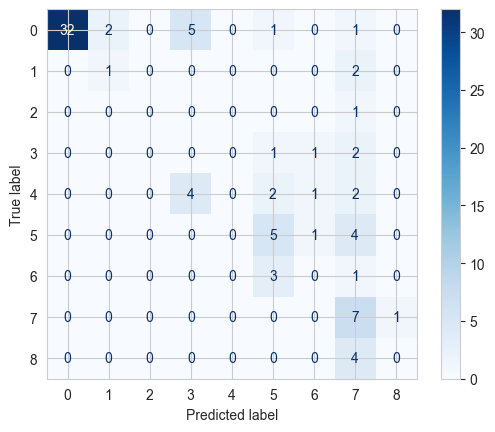

In [19]:
sns.set_style("whitegrid")
plt.figure(figsize=(16, 8)) 

plt.plot(
    df['Fecha'],
    df['Accesos'],
    label='Datos Reales (Observados)',
    color='#1f77b4',
    linewidth=2.5,
    alpha=0.8
)

plt.plot(
    df['Fecha'].loc[X_test.index],
    Y_pred,
    label='Predicción (Test)',
    color='#d62728',
    linestyle='--',
    linewidth=2.5,
    marker='o',
    markersize=5,
    alpha=0.9
)

plt.xlabel('Fecha', fontsize=14, labelpad=10)
plt.ylabel('Número de Accesos', fontsize=14, labelpad=10)
plt.title(
    'Rendimiento del Modelo: Predicciones vs. Valores Reales',
    fontsize=18,
    fontweight='bold',
    pad=20
)

plt.xticks(rotation=45, ha='right', fontsize=11)
plt.yticks(fontsize=11)

# Leyenda y Rejilla
plt.legend(loc='upper left', fontsize=12, frameon=True, shadow=True)
plt.grid(True, axis='both', linestyle='-', alpha=0.5)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

print(f1_score(y_test, Y_pred, average='weighted'))
print(classification_report(y_test, Y_pred))
print(confusion_matrix(y_test, Y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, Y_pred, cmap=plt.cm.Blues)

# LightGBM

In [20]:
X = df.drop(columns=['Fecha', 'Accesos'])
y = df['Accesos']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

In [21]:
os.makedirs('Archivos Auxiliares Class', exist_ok=True)
if "modelo_LightGBM.pkl" not in os.listdir('Archivos Auxiliares Class'):
    NUM_CLASS = df['Accesos'].max()+1
    tscv = TimeSeriesSplit(n_splits=5)
    param_grid = {
        'learning_rate': [0.005, 0.01, 0.05, 0.1],
        'n_estimators': [100, 300, 500, 1000],
        'num_leaves': [16, 32, 64, 128],
        # opcional (incluye solo si sospechas overfit)
        'max_depth': [5, 8, 10, 15],
    }

    print("\nIniciando entrenamiento y ajuste de hiperparámetros de LightGBM...")

    # 1. Búsqueda de Hyperparámetros
    grid_search = GridSearchCV(
        lgb.LGBMClassifier(num_class=NUM_CLASS,random_state=42, n_jobs=-1, objective='multiclass'),
        param_grid,  # Usando el conjunto de parámetros mejorado
        cv=tscv,
        scoring='f1_weighted',
        n_jobs=-1,
        verbose=2 # Aumentamos el verbose para seguir mejor el progreso
    )

    grid_search.fit(X_train, y_train)

    print(f'Mejores parámetros para LightGBM: {grid_search.best_params_}')

    # 2. Entrenamiento del modelo final con los mejores parámetros
    best_params = grid_search.best_params_
    model = lgb.LGBMClassifier(**best_params, num_class=NUM_CLASS, random_state=42, n_jobs=-1, objective='multiclass', metric='multi_logloss')
    model.fit(X_train, y_train)
    joblib.dump(model, 'Archivos Auxiliares Class/modelo_LightGBM.pkl')
    print("Modelo LightGBM guardado como 'Archivos Auxiliares Class/modelo_LightGBM.pkl'")
# Guardar el modelo
else:
    model = joblib.load('Archivos Auxiliares Class/modelo_LightGBM.pkl')
    print("Modelo LightGBM cargado desde 'Archivos Auxiliares Class/modelo_LightGBM.pkl'")

Modelo LightGBM cargado desde 'Archivos Auxiliares Class/modelo_LightGBM.pkl'


In [22]:
# Importancia de las características
importancias = model.feature_importances_
indices = np.argsort(importancias)[::-1]
print("\nImportancia de las características\n")
for i, idx in enumerate(indices):
    if idx < len(X.columns):
        print(f"{i + 1:2d}. {X.columns[idx]}: {importancias[idx]:.4f}")


Importancia de las características

 1. media_movil_7: 12911.0000
 2. Día: 12240.0000
 3. ewma_7: 10486.0000
 4. media_movil_30: 10421.0000
 5. lag_7: 9683.0000
 6. lag_21: 9425.0000
 7. lag_14: 8739.0000
 8. media_movil_14: 8163.0000
 9. ewma_30: 8011.0000
10. Semana_Semestre: 6473.0000
11. ewma_14: 6269.0000
12. dia_semana_sin: 6179.0000
13. dia_semana_cos: 5055.0000
14. mes_sin: 3164.0000
15. Mes: 3156.0000
16. mes_cos: 2405.0000
17. Vacaciones?: 1911.0000
18. Año: 407.0000
19. Semestre: 34.0000


In [23]:
# Eliminar características con importancia menor a 50
umbral_importancia = 50

# Solo considera las columnas usadas por el modelo y presentes en X_train/X_test
columnas_modelo = X.columns[:len(importancias)]
FEATURES = [col for col, imp in zip(columnas_modelo, importancias) 
            if imp >= umbral_importancia and col in X_train.columns and col in X_test.columns]

X_train = X_train[FEATURES]
X_test = X_test[FEATURES]

# Reentrenar el modelo con las características seleccionadas
model.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019198 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1016
[LightGBM] [Info] Number of data points in the train set: 333, number of used features: 18
[LightGBM] [Info] Start training from score -0.790863
[LightGBM] [Info] Start training from score -2.406945
[LightGBM] [Info] Start training from score -3.035554
[LightGBM] [Info] Start training from score -3.169085
[LightGBM] [Info] Start training from score -2.440847
[LightGBM] [Info] Start training from score -2.070473
[LightGBM] [Info] Start training from score -2.311635
[LightGBM] [Info] Start training from score -3.100092
[LightGBM] [Info] Start training from score -5.114995
[LightGBM] [Info] Start training from score -5.808142
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

,boosting_type,'gbdt'
,num_leaves,16
,max_depth,15
,learning_rate,0.01
,n_estimators,1000
,subsample_for_bin,200000
,objective,'multiclass'
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [24]:
Y_pred = model.predict(X_test)

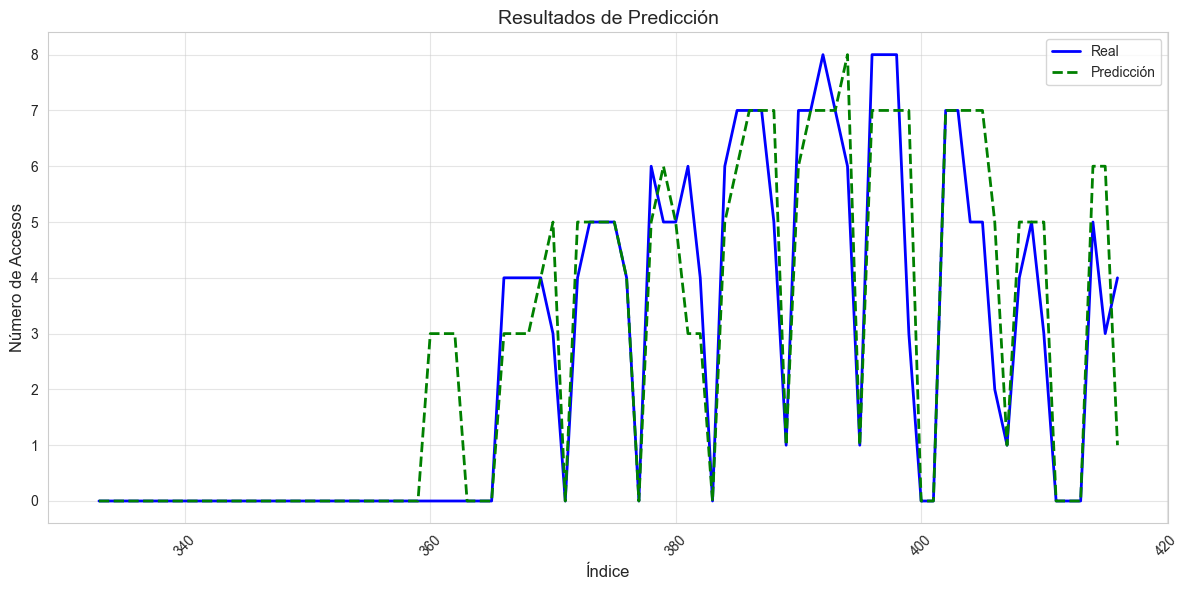

In [25]:
graph_pred(Y_pred, 'LightGBM_C')


Se han generado las siguientes visualizaciones:
- lightgbm_predicciones.png (Comparación de valores reales vs. predichos)
- lightgbm_importancia.png (Importancia de las variables)


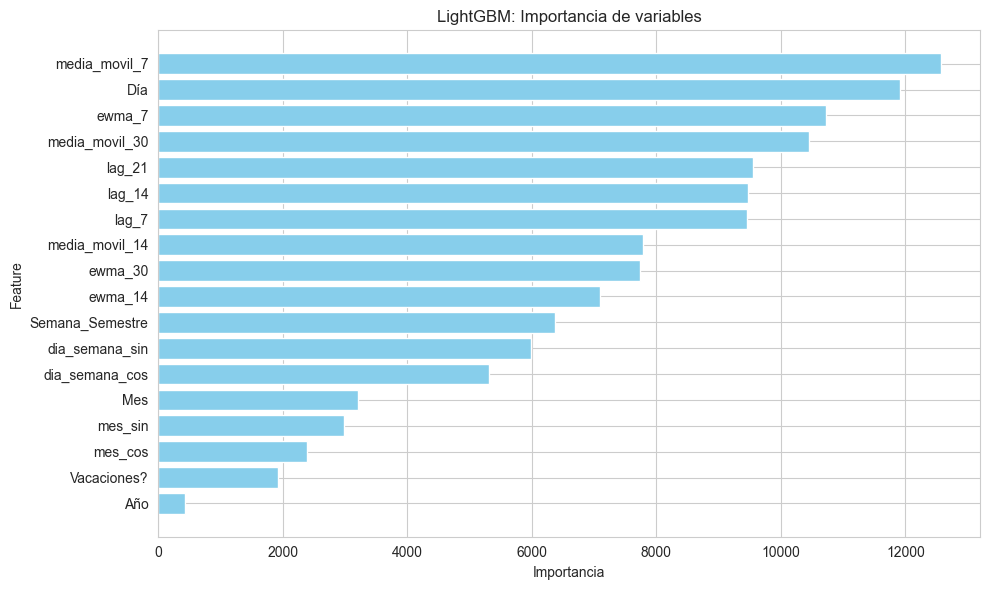

In [26]:
# Graficar importancia de variables
importances = model.feature_importances_
importance_df = pd.DataFrame({"Feature": FEATURES, "Importance": importances})
importance_df = importance_df.sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance_df["Feature"], importance_df["Importance"], color='skyblue')
plt.xlabel("Importancia")
plt.ylabel("Feature")
plt.title("LightGBM: Importancia de variables")
plt.gca().invert_yaxis() 
plt.tight_layout()
plt.savefig('lightgbm_importancia_C.png')

print("\nSe han generado las siguientes visualizaciones:")
print("- lightgbm_predicciones.png (Comparación de valores reales vs. predichos)")
print("- lightgbm_importancia.png (Importancia de las variables)")

0.645193865808694
              precision    recall  f1-score   support

           0       1.00      0.93      0.96        41
           1       0.75      1.00      0.86         3
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         4
           4       1.00      0.22      0.36         9
           5       0.42      0.50      0.45        10
           6       0.00      0.00      0.00         4
           7       0.43      0.75      0.55         8
           8       0.00      0.00      0.00         4

    accuracy                           0.64        84
   macro avg       0.40      0.38      0.35        84
weighted avg       0.71      0.64      0.65        84

[[38  0  0  3  0  0  0  0  0]
 [ 0  3  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  1  0  0  0]
 [ 0  0  0  0  0  2  1  1  0]
 [ 0  1  0  4  2  2  0  0  0]
 [ 0  0  0  0  0  5  2  3  0]
 [ 0  0  0  1  0  2  0  0  1]
 [ 0  0  0  0  0  0  2  6  0]
 [ 0  0  0  0  0  0  0  4  0]]


s:\Universidad\Analisis_de_Datos\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
s:\Universidad\Analisis_de_Datos\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
s:\Universidad\Analisis_de_Datos\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", res

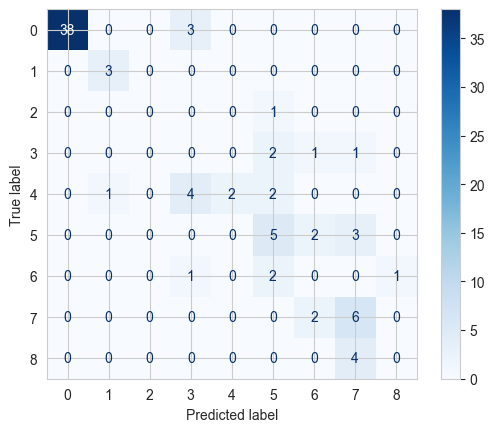

In [27]:
print(f1_score(y_test, Y_pred, average='weighted'))
print(classification_report(y_test, Y_pred))
print(confusion_matrix(y_test, Y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, Y_pred, cmap=plt.cm.Blues)

# CatBoost

In [28]:
X = df.drop(columns=['Fecha', 'Accesos'])
y = df['Accesos']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

In [29]:
os.makedirs('Archivos Auxiliares Class', exist_ok=True)
if "modelo_CatBoost.pkl" not in os.listdir('Archivos Auxiliares Class'):
    tscv = TimeSeriesSplit(n_splits=5)
    param_grid = {
        'iterations': [100, 300, 500, 1000],
        'learning_rate': [0.005, 0.01, 0.05, 0.1, 0.2],
        'depth': [4, 6, 8],
        'l2_leaf_reg': [1, 3, 5],
    }

    print("\nIniciando entrenamiento y ajuste de hiperparámetros de CatBoost...")

    # 1. Búsqueda de Hyperparámetros
    grid_search = GridSearchCV(
        CatBoostClassifier(loss_function='MultiClass', eval_metric='MultiClass', random_state=42, verbose=0),
        param_grid,  # Usando el conjunto de parámetros mejorado
        cv=tscv,
        scoring='f1_weighted',
        n_jobs=-1,
        verbose=2 # Aumentamos el verbose para seguir mejor el progreso
    )

    grid_search.fit(X_train, y_train)

    print(f'Mejores parámetros para CatBoost: {grid_search.best_params_}')

    # 2. Entrenamiento del modelo final con los mejores parámetros
    best_params = grid_search.best_params_
    model = CatBoostClassifier(**best_params, loss_function='MultiClass', eval_metric='MultiClass', random_state=42, verbose=0)
    model.fit(X_train, y_train)
    joblib.dump(model, 'Archivos Auxiliares Class/modelo_CatBoost.pkl')
    print("Modelo CatBoost guardado como 'Archivos Auxiliares Class/modelo_CatBoost.pkl'")
# Guardar el modelo
else:
    model = joblib.load('Archivos Auxiliares Class/modelo_CatBoost.pkl')
    print("Modelo CatBoost cargado desde 'Archivos Auxiliares Class/modelo_CatBoost.pkl'")

Modelo CatBoost cargado desde 'Archivos Auxiliares Class/modelo_CatBoost.pkl'


In [30]:
# Importancia de las características
importancias = model.get_feature_importance()
indices = np.argsort(importancias)[::-1]
print("\nImportancia de las características\n")
for i, idx in enumerate(indices):
    if idx < len(X.columns):
        print(f"{i + 1:2d}. {X.columns[idx]}: {importancias[idx]:.4f}")


Importancia de las características

 1. Semestre: 29.8561
 2. mes_cos: 10.2107
 3. Vacaciones?: 6.5209
 4. ewma_7: 6.4219
 5. dia_semana_cos: 5.5961
 6. media_movil_30: 5.2642
 7. mes_sin: 5.0555
 8. ewma_30: 4.7051
 9. media_movil_7: 3.8988
10. dia_semana_sin: 3.6498
11. Mes: 3.3716
12. media_movil_14: 3.0827
13. Semana_Semestre: 2.9921
14. Día: 2.8614
15. lag_14: 2.2415
16. lag_7: 2.1264
17. ewma_14: 1.7202
18. Año: 0.4249


In [31]:
importancias = model.get_feature_importance()
# Eliminar características con importancia menor a 2
umbral_importancia = 2

# Solo considera las columnas usadas por el modelo y presentes en X_train/X_test
columnas_modelo = X.columns[:len(importancias)]
FEATURES = [col for col, imp in zip(columnas_modelo, importancias) 
            if imp >= umbral_importancia and col in X_train.columns and col in X_test.columns]

X_train = X_train[FEATURES]
X_test = X_test[FEATURES]

# Reentrenar el modelo con las características seleccionadas
model.fit(X_train, y_train)

In [32]:
Y_pred = model.predict(X_test)

In [33]:
Y_pred = Y_pred.flatten()

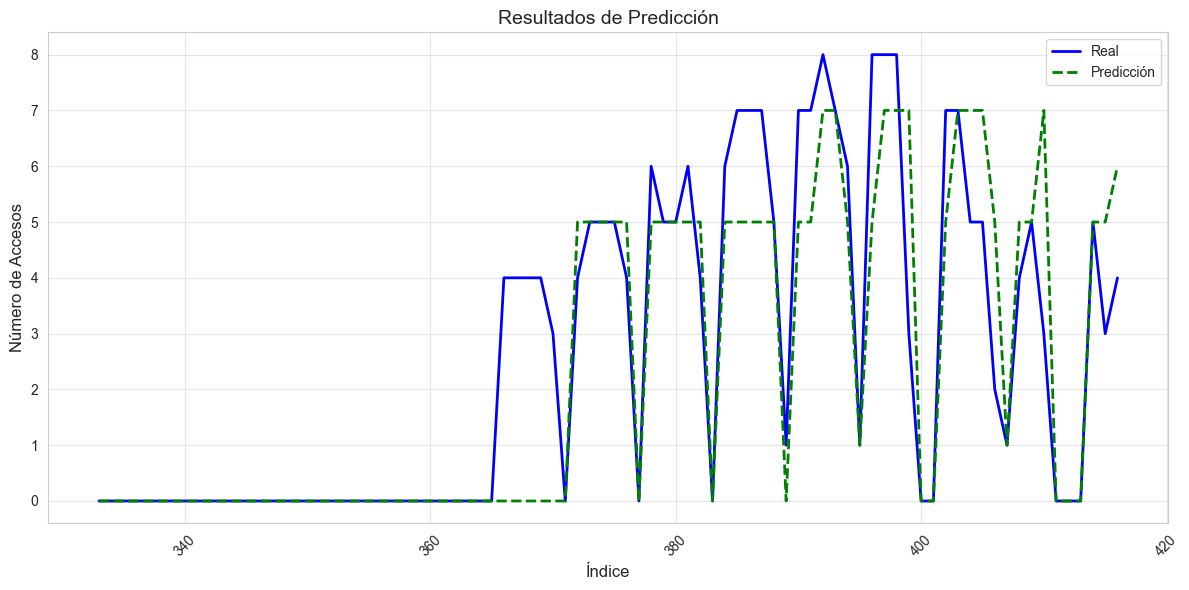

In [34]:
graph_pred(Y_pred, 'CatBoost_C')


Se han generado las siguientes visualizaciones:
- CatBoost_predicciones.png (Comparación de valores reales vs. predichos)
- CatBoost_importancia.png (Importancia de las variables)


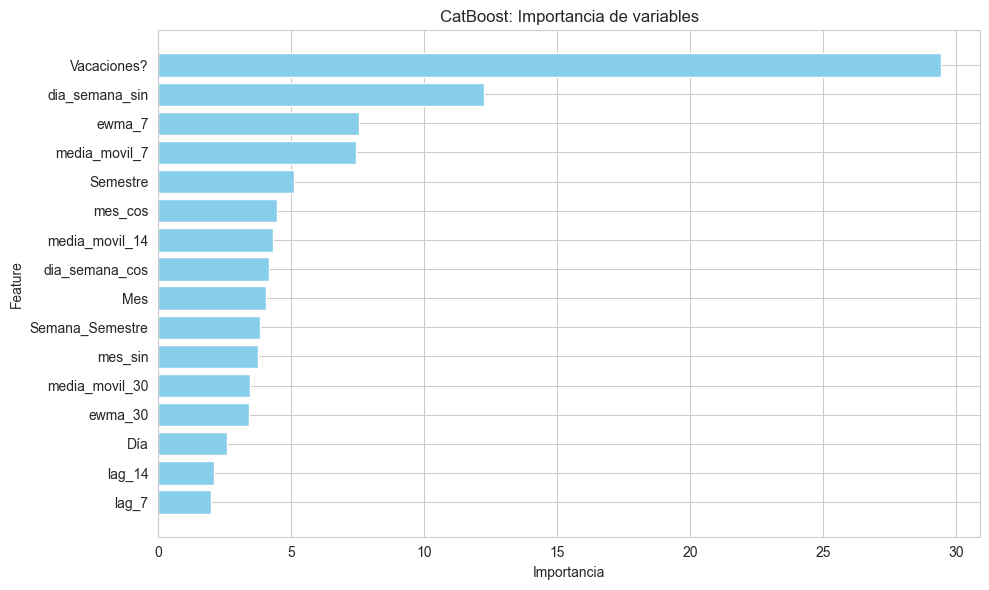

In [35]:
# Graficar importancia de variables
importances = model.get_feature_importance()
importance_df = pd.DataFrame({"Feature": FEATURES, "Importance": importances})
importance_df = importance_df.sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance_df["Feature"], importance_df["Importance"], color='skyblue')
plt.xlabel("Importancia")
plt.ylabel("Feature")
plt.title("CatBoost: Importancia de variables")
plt.gca().invert_yaxis() 
plt.tight_layout()
plt.savefig('CatBoost_importancia_C.png')

print("\nSe han generado las siguientes visualizaciones:")
print("- CatBoost_predicciones.png (Comparación de valores reales vs. predichos)")
print("- CatBoost_importancia.png (Importancia de las variables)")

0.560218178180363
              precision    recall  f1-score   support

           0       0.87      1.00      0.93        41
           1       1.00      0.67      0.80         3
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         4
           4       0.00      0.00      0.00         9
           5       0.32      0.80      0.46        10
           6       0.00      0.00      0.00         4
           7       0.22      0.25      0.24         8
           8       0.00      0.00      0.00         4

    accuracy                           0.63        84
   macro avg       0.27      0.30      0.27        84
weighted avg       0.52      0.63      0.56        84

[[41  0  0  0  0  0  0  0  0]
 [ 1  2  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  1  0  0  0]
 [ 1  0  0  0  0  1  0  2  0]
 [ 4  0  0  0  0  4  1  0  0]
 [ 0  0  0  0  0  8  0  2  0]
 [ 0  0  0  0  0  4  0  0  0]
 [ 0  0  0  0  0  6  0  2  0]
 [ 0  0  0  0  0  1  0  3  0]]


s:\Universidad\Analisis_de_Datos\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
s:\Universidad\Analisis_de_Datos\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
s:\Universidad\Analisis_de_Datos\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", res

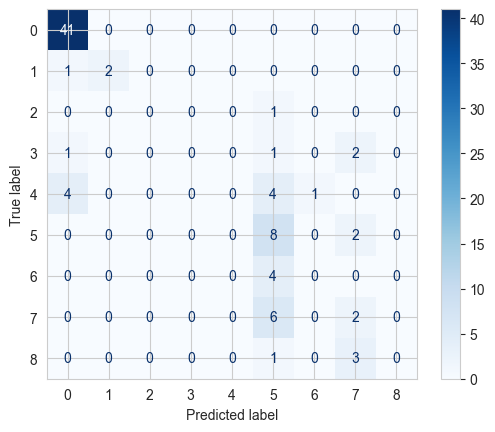

In [36]:
print(f1_score(y_test, Y_pred, average='weighted'))
print(classification_report(y_test, Y_pred))
print(confusion_matrix(y_test, Y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, Y_pred, cmap=plt.cm.Blues)

# XGBoost

In [37]:
X = df.drop(columns=['Fecha', 'Accesos'])
y = df['Accesos']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

In [38]:
os.makedirs('Archivos Auxiliares Class', exist_ok=True)
if "modelo_XGBoost.pkl" not in os.listdir('Archivos Auxiliares Class'):
    tscv = TimeSeriesSplit(n_splits=5)
    param_grid = {
        'n_estimators': [100, 300, 500, 1000],
        'max_depth': [3, 5, 7, 10],
        'min_child_weight': [1, 5, 10],
        'gamma': [0, 0.5, 1],
        'learning_rate': [0.005, 0.01, 0.05, 0.1],
    }

    print("\nIniciando entrenamiento y ajuste de hiperparámetros de XGBoost...")

    # 1. Búsqueda de Hyperparámetros
    grid_search = GridSearchCV(
        XGBClassifier(objective='multi:softmax', eval_metric='mlogloss', random_state=42),
        param_grid,  # Usando el conjunto de parámetros mejorado
        cv=tscv,
        scoring='f1_weighted',
        n_jobs=-1,
        verbose=2 # Aumentamos el verbose para seguir mejor el progreso
    )

    grid_search.fit(X_train, y_train)

    print(f'Mejores parámetros para XGBoost: {grid_search.best_params_}')

    # 2. Entrenamiento del modelo final con los mejores parámetros
    best_params = grid_search.best_params_
    model = XGBClassifier(**best_params, objective='multi:softmax', eval_metric='mlogloss', random_state=42)
    model.fit(X_train, y_train)
    joblib.dump(model, 'Archivos Auxiliares Class/modelo_XGBoost.pkl')
    print("Modelo XGBoost guardado como 'Archivos Auxiliares Class/modelo_XGBoost.pkl'")
# Guardar el modelo
else:
    model = joblib.load('Archivos Auxiliares Class/modelo_XGBoost.pkl')
    print("Modelo XGBoost cargado desde 'Archivos Auxiliares Class/modelo_XGBoost.pkl'")

Modelo XGBoost cargado desde 'Archivos Auxiliares Class/modelo_XGBoost.pkl'


In [39]:
importancias = model.feature_importances_
indices = np.argsort(importancias)[::-1]
print("\nImportancia de las características\n")
for i, idx in enumerate(indices):
    if idx < len(X.columns):
        print(f"{i + 1:2d}. {X.columns[idx]}: {importancias[idx]:.4f}")


Importancia de las características

 1. Vacaciones?: 0.2733
 2. Año: 0.1338
 3. media_movil_14: 0.1226
 4. ewma_7: 0.0882
 5. ewma_30: 0.0708
 6. dia_semana_sin: 0.0536
 7. ewma_14: 0.0523
 8. media_movil_30: 0.0379
 9. media_movil_7: 0.0337
10. Mes: 0.0330
11. Día: 0.0268
12. Semana_Semestre: 0.0192
13. lag_21: 0.0183
14. dia_semana_cos: 0.0128
15. mes_sin: 0.0113
16. lag_14: 0.0080
17. lag_7: 0.0036
18. mes_cos: 0.0008
19. Semestre: 0.0000


In [40]:
# Eliminar características con importancia menor a 2
umbral_importancia = 0.01

# Solo considera las columnas usadas por el modelo y presentes en X_train/X_test
columnas_modelo = X.columns[:len(importancias)]
FEATURES = [col for col, imp in zip(columnas_modelo, importancias) 
            if imp >= umbral_importancia and col in X_train.columns and col in X_test.columns]

X_train = X_train[FEATURES]
X_test = X_test[FEATURES]

# Reentrenar el modelo con las características seleccionadas
model.fit(X_train, y_train)

,objective,'multi:softmax'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'mlogloss'


In [41]:
X_train.head()

,Día,Mes,Año,Vacaciones?,media_movil_7,media_movil_14,media_movil_30,mes_sin,dia_semana_sin,dia_semana_cos,ewma_7,ewma_14,ewma_30,Semana_Semestre,lag_21
0,8,1,2024,0,206.428571,111.928571,224.380952,0.5,0.000000,1.000000,199.916289,223.143104,380.572820,0,953.0
1,9,1,2024,0,236.714286,118.357143,223.818182,0.5,0.781831,0.623490,202.937217,221.657357,369.697154,0,549.0
2,10,1,2024,0,277.142857,138.571429,226.391304,0.5,0.974928,-0.222521,222.952913,229.836376,364.103789,0,71.0
3,11,1,2024,0,281.285714,151.785714,224.666667,0.5,0.433884,-0.900969,213.464685,223.858192,352.548706,0,739.0
4,12,1,2024,0,250.714286,170.214286,226.000000,0.5,-0.433884,-0.900969,224.598513,228.410433,346.448790,0,383.0


In [42]:
Y_pred = model.predict(X_test)

In [43]:
Y_pred = Y_pred.flatten()

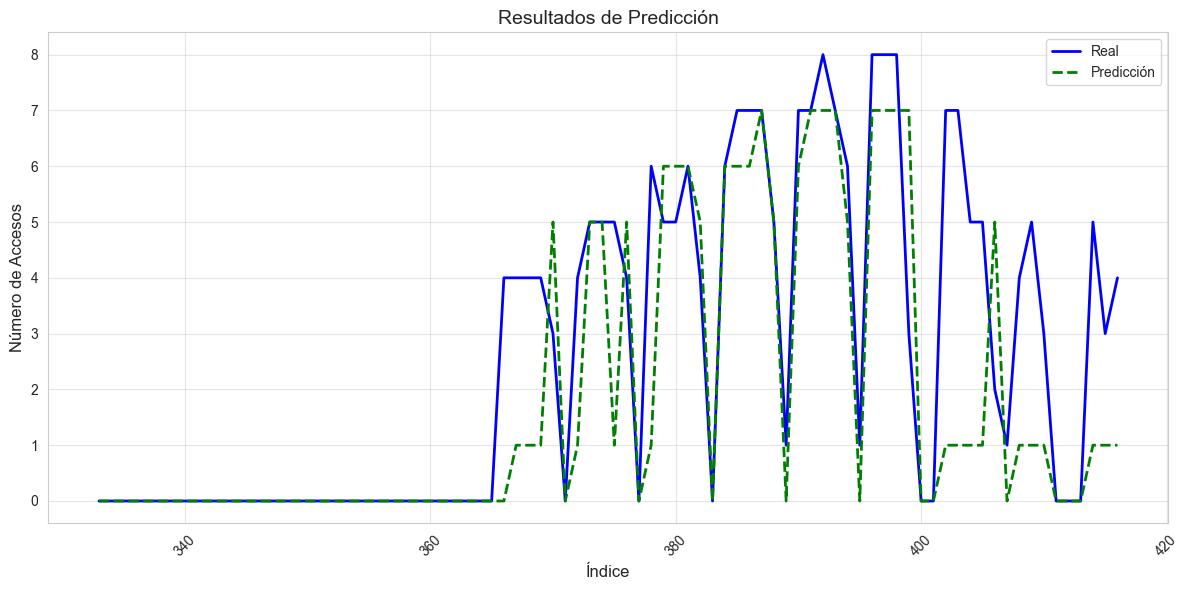

In [44]:
graph_pred(Y_pred, 'XGBoost_C')


Se han generado las siguientes visualizaciones:
- XGBoost_predicciones.png (Comparación de valores reales vs. predichos)
- XGBoost_importancia.png (Importancia de las variables)


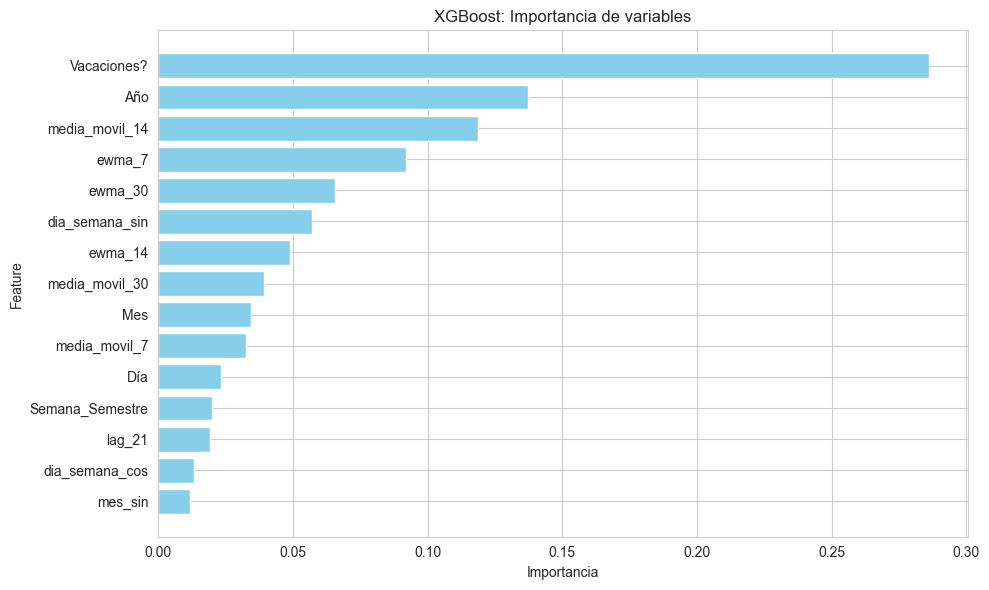

In [45]:
# Graficar importancia de variables
importances = model.feature_importances_
importance_df = pd.DataFrame({"Feature": FEATURES, "Importance": importances})
importance_df = importance_df.sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance_df["Feature"], importance_df["Importance"], color='skyblue')
plt.xlabel("Importancia")
plt.ylabel("Feature")
plt.title("XGBoost: Importancia de variables")
plt.gca().invert_yaxis() 
plt.tight_layout()
plt.savefig('XGBoost_importancia_C.png')

print("\nSe han generado las siguientes visualizaciones:")
print("- XGBoost_predicciones.png (Comparación de valores reales vs. predichos)")
print("- XGBoost_importancia.png (Importancia de las variables)")

0.5581059767106279
              precision    recall  f1-score   support

           0       0.91      1.00      0.95        41
           1       0.00      0.00      0.00         3
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         4
           4       0.00      0.00      0.00         9
           5       0.38      0.30      0.33        10
           6       0.29      0.50      0.36         4
           7       0.38      0.38      0.38         8
           8       0.00      0.00      0.00         4

    accuracy                           0.58        84
   macro avg       0.22      0.24      0.23        84
weighted avg       0.54      0.58      0.56        84

[[41  0  0  0  0  0  0  0  0]
 [ 3  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  1  0  0  0]
 [ 0  2  0  0  0  1  0  1  0]
 [ 1  6  0  0  0  2  0  0  0]
 [ 0  5  0  0  0  3  2  0  0]
 [ 0  1  0  0  0  1  2  0  0]
 [ 0  2  0  0  0  0  3  3  0]
 [ 0  0  0  0  0  0  0  4  0]]


s:\Universidad\Analisis_de_Datos\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
s:\Universidad\Analisis_de_Datos\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
s:\Universidad\Analisis_de_Datos\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", res

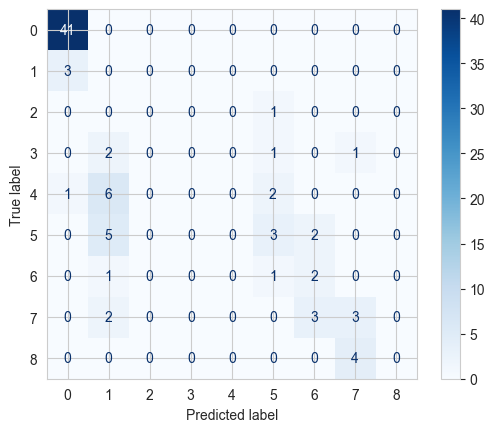

In [46]:
print(f1_score(y_test, Y_pred, average='weighted'))
print(classification_report(y_test, Y_pred))
print(confusion_matrix(y_test, Y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, Y_pred, cmap=plt.cm.Blues)

# Logistic

In [69]:
X = df.drop(columns=['Fecha', 'Accesos'])
y = df['Accesos']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

In [70]:
os.makedirs('Archivos Auxiliares Class', exist_ok=True)
if "modelo_Logistic.pkl" not in os.listdir('Archivos Auxiliares Class'):
    tscv = TimeSeriesSplit(n_splits=5)
    max_iter= [2000, 5000, 10000]
    C= [0.001, 0.01, 0.1, 1, 10, 100]
    penalty= [None, 'l2', 'l1','elasticnet']
    solver= ['lbfgs', 'saga'] 
    best_params = {}
    max_f1 = -np.inf
    for mi in max_iter:
        for c in C:
            for p in penalty:
                for s in solver:
                    if p in ['elasticnet', 'l1'] and s not in ['saga']:
                        continue 
                    if p in [None, 'l2'] and s not in ['lbfgs', 'saga']:
                        continue 
                    fold_scores = []
                    for train_index, val_index in tscv.split(X_train):
                        X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
                        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
                        try:
                            if p == 'elasticnet':
                                grid = LogisticRegression(max_iter=mi, C=c, penalty=p, solver=s, l1_ratio=0.5, random_state=42, verbose=0)
                            else:
                                grid = LogisticRegression(max_iter=mi, C=c, penalty=p, solver=s, random_state=42, verbose=0)
                            grid.fit(X_train_fold, y_train_fold)
                            Y_pred_selection = grid.predict(X_val_fold)
                            score = f1_score(y_val_fold, Y_pred_selection, average='weighted')
                            fold_scores.append(score)
                        except Exception as e:
                            fold_scores.append(-1.0)
                    if fold_scores:
                        mean_score = np.mean(fold_scores)
                        if mean_score > max_f1:
                            max_f1 = mean_score
                            best_params = {'max_iter': mi, 'C': c, 'penalty': p, 'solver': s}
                            print(f"NEW BEST F1 ({max_f1:.4f}): {best_params}")
    if best_params.get('solver') == 'elasticnet':
        model = LogisticRegression(**best_params, l1_ratio=0.5, random_state=42)
    else:
        model = LogisticRegression(**best_params, random_state=42)
    model.fit(X_train, y_train)
    joblib.dump(model, 'Archivos Auxiliares Class/modelo_Logistic.pkl')
    print("Modelo guardado como 'Archivos Auxiliares Class/modelo_Logistic.pkl'")
else:
    model = joblib.load('Archivos Auxiliares Class/modelo_Logistic.pkl')
    print("Modelo cargado desde 'Archivos Auxiliares Class/modelo_Logistic.pkl'")

Modelo cargado desde 'Archivos Auxiliares Class/modelo_Logistic.pkl'


In [71]:
# Importancia de las características
abs_coefs = abs(model.coef_)
importances = abs_coefs.max(axis=0)
indices = np.argsort(importancias)[::-1]
print("\nImportancia de las características\n")
for i, idx in enumerate(indices):
    if idx < len(X.columns):
        print(f"{i + 1:2d}. {X.columns[idx]}: {importancias[idx]:.4f}")


Importancia de las características

 1. Vacaciones?: 0.2733
 2. Año: 0.1338
 3. media_movil_14: 0.1226
 4. ewma_7: 0.0882
 5. ewma_30: 0.0708
 6. dia_semana_sin: 0.0536
 7. ewma_14: 0.0523
 8. media_movil_30: 0.0379
 9. media_movil_7: 0.0337
10. Mes: 0.0330
11. Día: 0.0268
12. Semana_Semestre: 0.0192
13. lag_21: 0.0183
14. dia_semana_cos: 0.0128
15. mes_sin: 0.0113
16. lag_14: 0.0080
17. lag_7: 0.0036
18. mes_cos: 0.0008
19. Semestre: 0.0000


In [72]:
abs_coefs = abs(model.coef_)
importances = abs_coefs.max(axis=0)
# Eliminar características con importancia menor a 2
umbral_importancia = 0.015

# Solo considera las columnas usadas por el modelo y presentes en X_train/X_test
columnas_modelo = X.columns[:len(importancias)]
FEATURES = [col for col, imp in zip(columnas_modelo, importancias) 
            if imp >= umbral_importancia and col in X_train.columns and col in X_test.columns]

X_train = X_train[FEATURES]
X_test = X_test[FEATURES]

# Reentrenar el modelo con las características seleccionadas
model.fit(X_train, y_train)

s:\Universidad\Analisis_de_Datos\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 5000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=5000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,penalty,'l2'
,dual,False
,tol,0.0001
,C,0.1
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'lbfgs'
,max_iter,5000
,multi_class,'deprecated'


In [73]:
Y_pred = model.predict(X_test)

In [74]:
Y_pred = Y_pred.flatten()

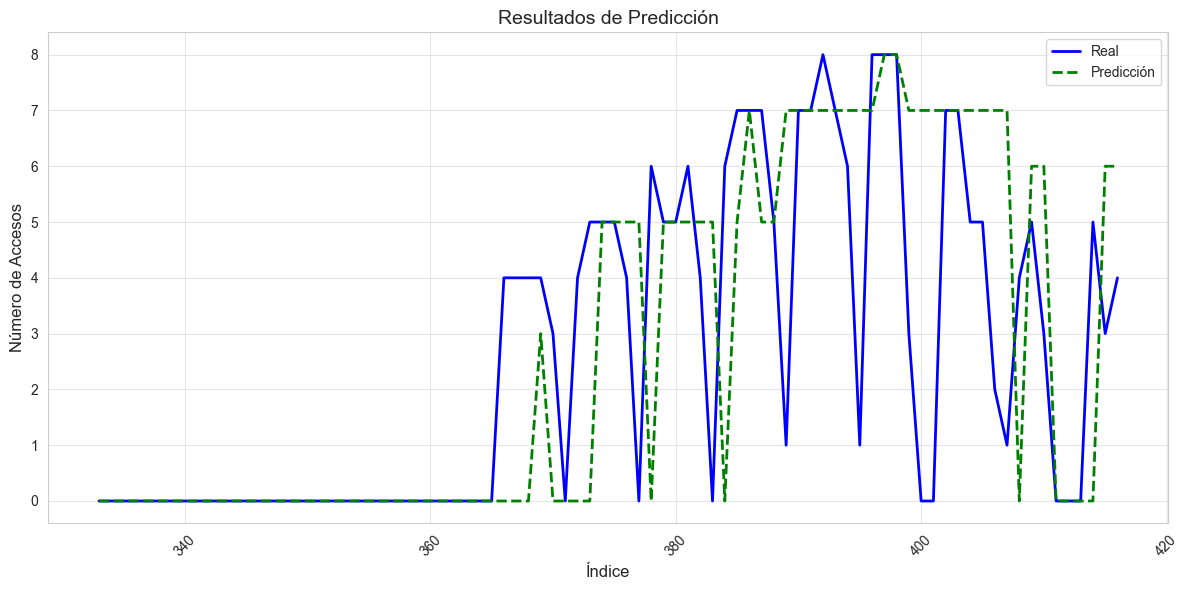

In [75]:
graph_pred(Y_pred, 'Logistic_C')


Se han generado las siguientes visualizaciones:
- Logistic_predicciones.png (Comparación de valores reales vs. predichos)
- Logistic_importancia.png (Importancia de las variables)


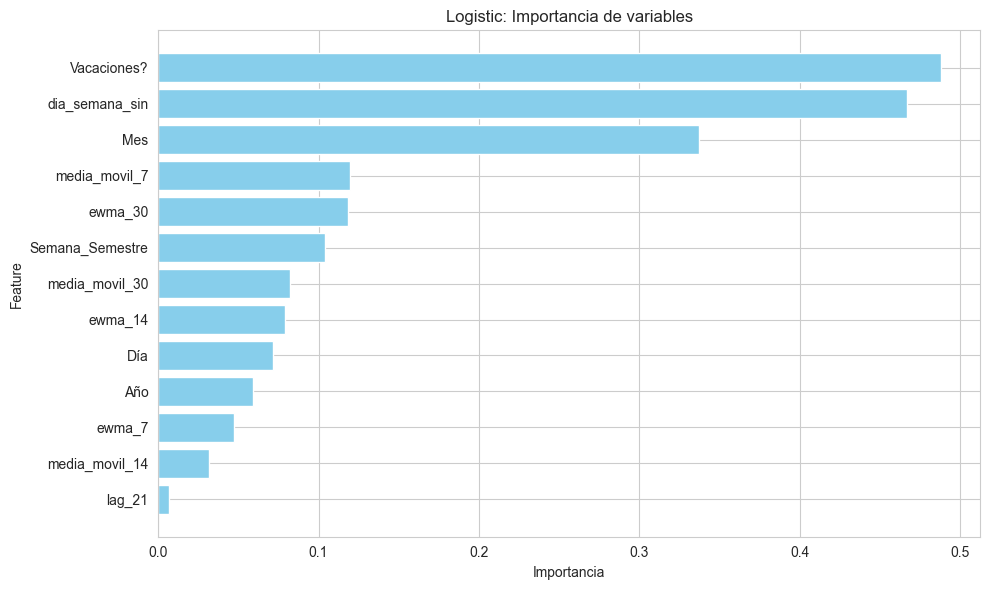

In [76]:
# Graficar importancia de variables
abs_coefs = abs(model.coef_)
importances = abs_coefs.max(axis=0)
importance_df = pd.DataFrame({"Feature": FEATURES, "Importance": importances})
importance_df = importance_df.sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance_df["Feature"], importance_df["Importance"], color='skyblue')
plt.xlabel("Importancia")
plt.ylabel("Feature")
plt.title("Logistic: Importancia de variables")
plt.gca().invert_yaxis() 
plt.tight_layout()
plt.savefig('Logistic_importancia_C.png')

print("\nSe han generado las siguientes visualizaciones:")
print("- Logistic_predicciones.png (Comparación de valores reales vs. predichos)")
print("- Logistic_importancia.png (Importancia de las variables)")

0.5402583527583527
              precision    recall  f1-score   support

           0       0.79      0.90      0.84        41
           1       0.00      0.00      0.00         3
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         4
           4       0.00      0.00      0.00         9
           5       0.42      0.50      0.45        10
           6       0.00      0.00      0.00         4
           7       0.33      0.75      0.46         8
           8       1.00      0.50      0.67         4

    accuracy                           0.60        84
   macro avg       0.28      0.29      0.27        84
weighted avg       0.51      0.60      0.54        84

[[37  0  0  0  0  2  0  2  0]
 [ 0  0  0  0  0  0  0  3  0]
 [ 0  0  0  0  0  0  0  1  0]
 [ 1  0  0  0  0  0  2  1  0]
 [ 5  0  0  1  0  2  1  0  0]
 [ 2  0  0  0  0  5  1  2  0]
 [ 2  0  0  0  0  1  0  1  0]
 [ 0  0  0  0  0  2  0  6  0]
 [ 0  0  0  0  0  0  0  2  2]]


s:\Universidad\Analisis_de_Datos\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
s:\Universidad\Analisis_de_Datos\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
s:\Universidad\Analisis_de_Datos\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", res

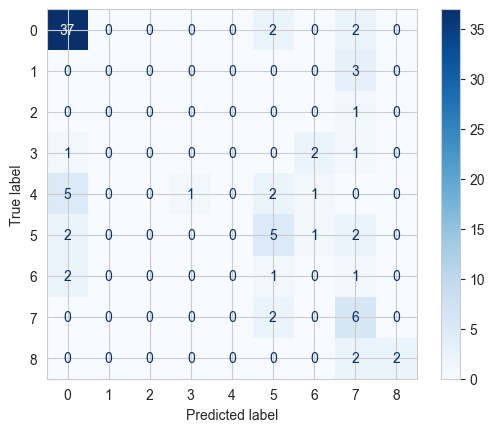

In [77]:
print(f1_score(y_test, Y_pred, average='weighted'))
print(classification_report(y_test, Y_pred))
print(confusion_matrix(y_test, Y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, Y_pred, cmap=plt.cm.Blues)

# KNN

In [78]:
X = df.drop(columns=['Fecha', 'Accesos'])
y = df['Accesos']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

In [79]:
os.makedirs('Archivos Auxiliares Class', exist_ok=True)
if "modelo_KNN.pkl" not in os.listdir('Archivos Auxiliares Class'):
    tscv = TimeSeriesSplit(n_splits=5)
    param_grid = {
        'n_neighbors': [3, 5, 7, 9, 11, 15, 21, 31],
        'weights': ['uniform', 'distance'],
        'p': [1, 2] 
    }
    grid_search = GridSearchCV(
        KNeighborsClassifier(),
        param_grid,
        cv=tscv,
        scoring='f1_weighted',
        n_jobs=-1,
        verbose=2 # Aumentamos el verbose para seguir mejor el progreso
    )
    grid_search.fit(X_train, y_train)
    best_params = grid_search.best_params_
    model = KNeighborsClassifier(**best_params)
    model.fit(X_train, y_train)
    joblib.dump(model, 'Archivos Auxiliares Class/modelo_KNN.pkl')
    print("Modelo guardado como 'Archivos Auxiliares Class/modelo_KNN.pkl'")
else:
    model = joblib.load('Archivos Auxiliares Class/modelo_KNN.pkl')
    print("Modelo cargado desde 'Archivos Auxiliares Class/modelo_KNN.pkl'")

Modelo cargado desde 'Archivos Auxiliares Class/modelo_KNN.pkl'


In [80]:
selector = SelectKBest(score_func=f_classif, k=15)
selector.fit(X_train, y_train)
FEATURES = X_train.columns[selector.get_support()]

X_train = X_train[FEATURES]
X_test = X_test[FEATURES]

model.fit(X_train, y_train)

,n_neighbors,15
,weights,'distance'
,algorithm,'auto'
,leaf_size,30
,p,1
,metric,'minkowski'
,metric_params,None
,n_jobs,None


In [81]:
Y_pred = model.predict(X_test)

In [82]:
Y_pred = Y_pred.flatten()

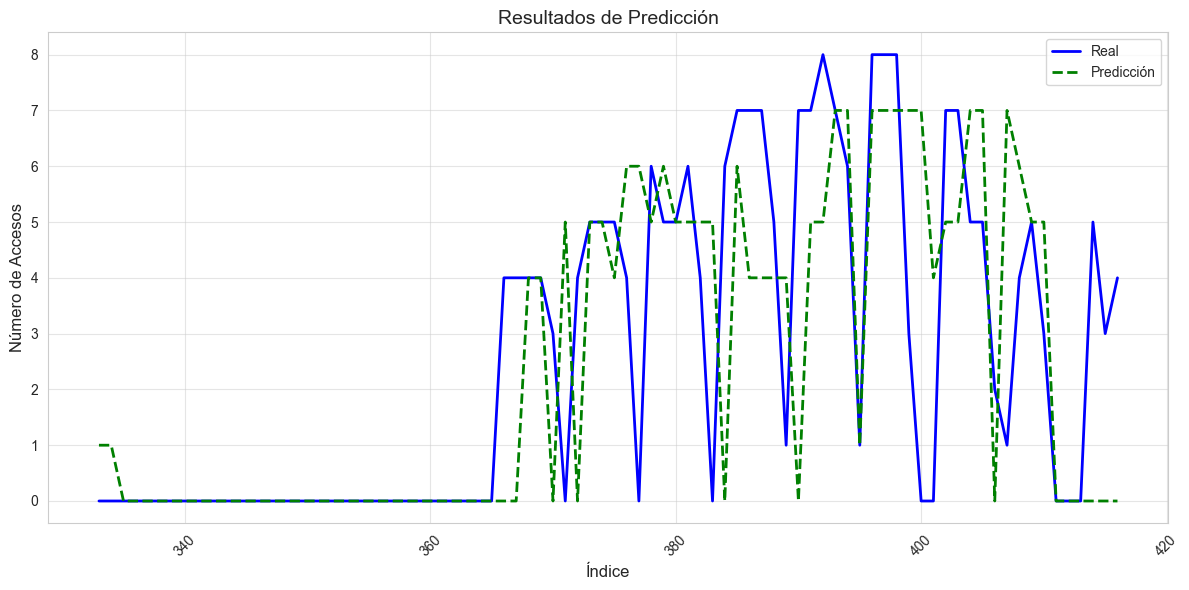

In [83]:
graph_pred(Y_pred, 'KNN_C')

0.47785558667911615
              precision    recall  f1-score   support

           0       0.77      0.83      0.80        41
           1       0.33      0.33      0.33         3
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         4
           4       0.25      0.22      0.24         9
           5       0.29      0.40      0.33        10
           6       0.00      0.00      0.00         4
           7       0.10      0.12      0.11         8
           8       0.00      0.00      0.00         4

    accuracy                           0.50        84
   macro avg       0.19      0.21      0.20        84
weighted avg       0.46      0.50      0.48        84

[[34  2  0  0  1  2  1  1  0]
 [ 0  1  0  0  1  0  0  1  0]
 [ 1  0  0  0  0  0  0  0  0]
 [ 2  0  0  0  0  1  0  1  0]
 [ 4  0  0  0  2  1  2  0  0]
 [ 1  0  0  0  2  4  1  2  0]
 [ 1  0  0  0  0  2  0  1  0]
 [ 1  0  0  0  2  3  1  1  0]
 [ 0  0  0  0  0  1  0  3  0]]


s:\Universidad\Analisis_de_Datos\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
s:\Universidad\Analisis_de_Datos\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
s:\Universidad\Analisis_de_Datos\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", res

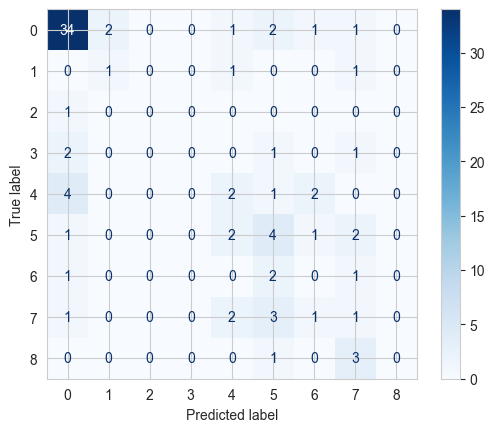

In [84]:
print(f1_score(y_test, Y_pred, average='weighted'))
print(classification_report(y_test, Y_pred))
print(confusion_matrix(y_test, Y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, Y_pred, cmap=plt.cm.Blues)

# GaussianNB

In [85]:
X = df.drop(columns=['Fecha', 'Accesos'])
y = df['Accesos']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)
class_counts = Counter(y_train)
total_samples = len(y_train)
actual_proportions = [count / total_samples for class_label, count in sorted(class_counts.items())]
num_classes = len(class_counts)
uniform_prior = 1.0 / num_classes
weighted_priors = [uniform_prior] * num_classes

In [86]:
os.makedirs('Archivos Auxiliares Class', exist_ok=True)
if "modelo_GaussianNB.pkl" not in os.listdir('Archivos Auxiliares Class'):
    tscv = TimeSeriesSplit(n_splits=5)
    param_grid = {
        'var_smoothing': [1e-10, 1e-9, 1e-8, 1e-7, 1e-6]
    }
    grid_search = GridSearchCV(
        GaussianNB(priors=weighted_priors),
        param_grid,
        cv=tscv,
        scoring='f1_weighted',
        n_jobs=-1,
        verbose=2 # Aumentamos el verbose para seguir mejor el progreso
    )
    grid_search.fit(X_train, y_train)
    best_params = grid_search.best_params_
    model = GaussianNB(**best_params, priors=weighted_priors)
    model.fit(X_train, y_train)
    joblib.dump(model, 'Archivos Auxiliares Class/modelo_GaussianNB.pkl')
    print("Modelo guardado como 'Archivos Auxiliares Class/modelo_GaussianNB.pkl'")
else:
    model = joblib.load('Archivos Auxiliares Class/modelo_GaussianNB.pkl')
    print("Modelo cargado desde 'Archivos Auxiliares Class/modelo_GaussianNB.pkl'")

Modelo cargado desde 'Archivos Auxiliares Class/modelo_GaussianNB.pkl'


In [87]:
selector = SelectKBest(score_func=f_classif, k=15)
selector.fit(X_train, y_train)
FEATURES = X_train.columns[selector.get_support()]

X_train = X_train[FEATURES]
X_test = X_test[FEATURES]

model.fit(X_train, y_train)

,priors,"[0.1, 0.1, ...]"
,var_smoothing,1e-10


In [88]:
print(FEATURES)

Index(['Mes', 'Año', 'Semestre', 'Vacaciones?', 'media_movil_7',
       'media_movil_14', 'media_movil_30', 'mes_sin', 'mes_cos',
       'dia_semana_sin', 'ewma_7', 'ewma_14', 'ewma_30', 'lag_7', 'lag_14'],
      dtype='object')


In [89]:
Y_pred = model.predict(X_test)

In [90]:
#Y_pred = Y_pred.flatten()

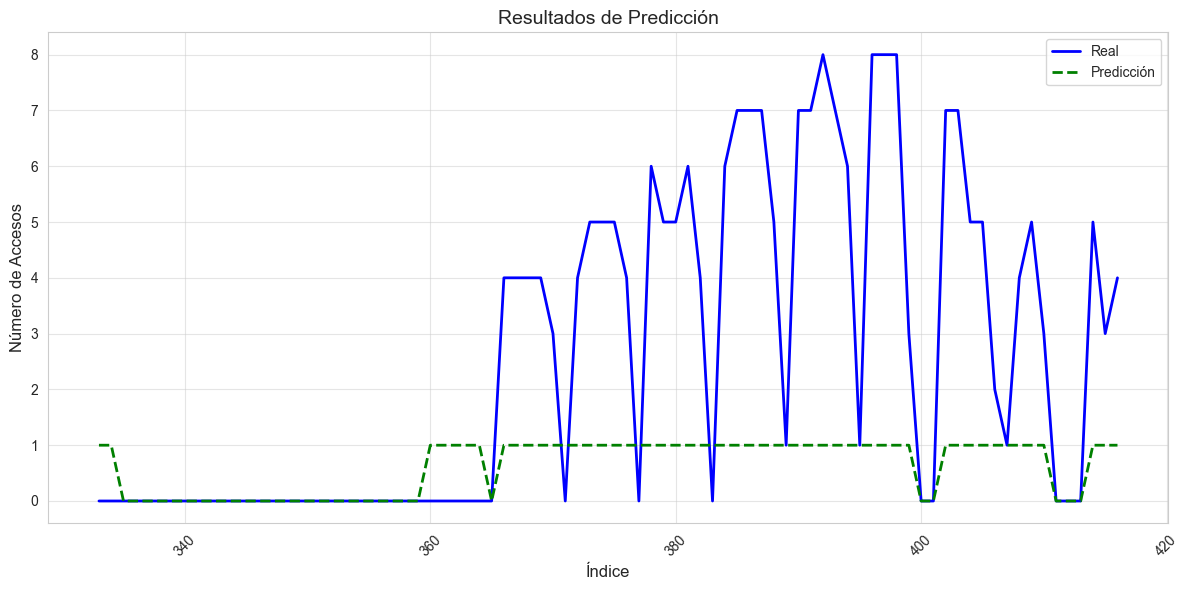

In [91]:
graph_pred(Y_pred, 'GaussianNB_C')

0.4241307634164777
              precision    recall  f1-score   support

           0       1.00      0.76      0.86        41
           1       0.06      1.00      0.11         3
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         4
           4       0.00      0.00      0.00         9
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00         4
           7       0.00      0.00      0.00         8
           8       0.00      0.00      0.00         4

    accuracy                           0.40        84
   macro avg       0.12      0.20      0.11        84
weighted avg       0.49      0.40      0.42        84

[[31 10  0  0  0  0  0  0  0]
 [ 0  3  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  0  0]
 [ 0  4  0  0  0  0  0  0  0]
 [ 0  9  0  0  0  0  0  0  0]
 [ 0 10  0  0  0  0  0  0  0]
 [ 0  4  0  0  0  0  0  0  0]
 [ 0  8  0  0  0  0  0  0  0]
 [ 0  4  0  0  0  0  0  0  0]]


s:\Universidad\Analisis_de_Datos\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
s:\Universidad\Analisis_de_Datos\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
s:\Universidad\Analisis_de_Datos\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", res

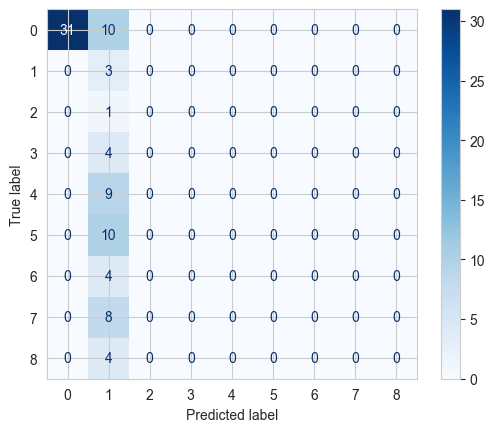

In [92]:
print(f1_score(y_test, Y_pred, average='weighted'))
print(classification_report(y_test, Y_pred))
print(confusion_matrix(y_test, Y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, Y_pred, cmap=plt.cm.Blues)